In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Utils.ga import *
from Utils.tradingrule_changelogr import *

import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data preprocessing

In [15]:
data = pd.read_csv("data/AUDUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

,Open,High,Low,Close
0,0.70613,0.70613,0.70575,0.70575
1,0.70575,0.70579,0.70568,0.70579
2,0.70579,0.70598,0.70578,0.70595
3,0.70596,0.70618,0.70594,0.70618
4,0.70618,0.70628,0.70593,0.70595


In [16]:
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

In [17]:
# %%time
# trading_rule_params = trainTradingRuleFeatures(X_train)

### GridSearch结果保持一致，所以直接保存下来用就好，换了新数据只用算一次

In [18]:
# # Dumps the rule parameters
# params_json = json.dumps(trading_rule_params)
# with open("trading_rule_params.json", "w") as jsonFile:
#     jsonFile.write(params_json)
#     jsonFile.close()

In [19]:
# Read the rule parameters
with open("trading_rule_params.json", "r") as jsonFile:
    trading_rule_params = json.load(jsonFile)
    print(trading_rule_params)

[[1, 3], [1, 3], [1, 3], [3, 3], [1, 7], [3, 3], [3, 41], [1, 7], [1, 3], [3, 55], [3, 0], [3, 55, 50], [3, 20, 0], 11, 3, 27]


In [20]:
%%time
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

CPU times: user 3.33 s, sys: 4.03 ms, total: 3.34 s
Wall time: 3.33 s


### Genetic Algorithm to Find the Optimal Combination of Rules

In [21]:
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))

### 思考下为什么原版代码的曲线会突然就往下打下去，SSR应该是maximize优化
### 但是现有代码居然效果更好了，比较confused, 思考下原因，注意分析到底有没有未来函数
### 跑几遍结果不一样，就不稳定，还是要分析原因

(array([0]),)
[0.0005240330422655977, 0.0008062918198721332, 0.0008034250674424299, 0.0006996113695226373, 0.0006279745624687315, 0.000531846592793629, 0.0004276852512063636, 0.00039371299919061686, 0.00038890602964337603, 0.00040094128584135784, 0.0004108236289655339, 0.00042956801783873637, 0.00046546518672735746, 0.0004688564048895295, 0.00045893505709276904, 0.0004712813790402732, 0.0004594316429611819, 0.0004586731814824831, 0.0004764045739220803, 0.0004690741067114181, 0.0004650707326581415, 0.0004448037289295352, 0.0004567320970216662, 0.0004653588027152411, 0.0004571268968325601, 0.00044434076548012985, 0.0004483704101617716, 0.0004503346551941776, 0.0004522082932527794, 0.00045243701202315404, 0.00042625110423853474, 0.0004558311199048436, 0.0004489554162078762, 0.0004538175618147784, 0.00045894169614207425, 0.00044308393045382834, 0.00044318635812834933, 0.00043121437173050545, 0.00041685536156222124, 0.0004338191962459932, 0.00044799177882983983, 0.00046679475672238395, 0.00

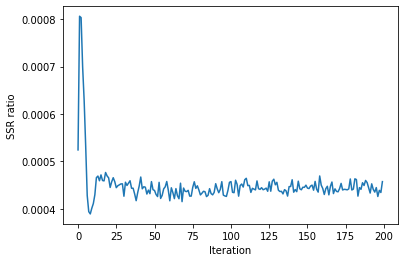

CPU times: user 43.1 s, sys: 1.48 s, total: 44.6 s
Wall time: 44.6 s


In [22]:
%%time
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

In [23]:
position = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position /= np.max(abs(position))
print('Training data evaluation:')
evaluate(position, X_trading_rule_train.logr)
port_r_train = X_trading_rule_train.logr*position

Training data evaluation:
The maximum position is 0.954, the mean postiion is 0.433800.
The return over the period is: 14.58%
Maximum drawdown is: -0.478%
SR ratio is: 8.688


In [24]:
position = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position /= np.max(abs(position))
print('Testing data evaluation:')
evaluate(position, X_trading_rule_test.logr)
port_r_test = X_trading_rule_test.logr*position

Testing data evaluation:
The maximum position is 0.852, the mean postiion is 0.479114.
The return over the period is: 7.79%
Maximum drawdown is: -0.156%
SR ratio is: 5.501


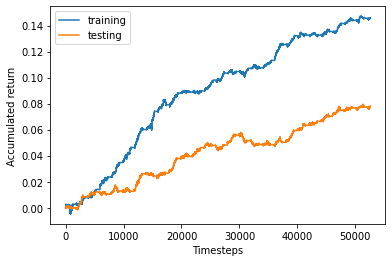

In [25]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.show()